In [21]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from sherpa import ui

%matplotlib inline

In [22]:
SOTA2015_FIT = [
 0.17633001726381758,
 1.0531644850527571,
 -0.32100853356502734,
 -1.5618156890474242,
 0.75267486019324359,
 0.16378000152347474]

In [41]:
with tables.openFile('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'warm_pix': 'n100_warm_frac',
             'mag': 'mag_aca',
             'known_bad': 'known_bad',
             'color': 'color1'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((year - year_q0) * 4)).astype('f4')
acqs['fail'] = 1.0 - acqs['obc_id'].astype(np.int)

In [42]:
data_all = acqs.group_by('quarter')
data_all['mag10'] = data_all['mag'] - 10.0
data_all.sort('year')
ok = (data_all['year'] > 2007) & (data_all['mag'] > 7.5) & (data_all['mag'] < 11.0)
data_all = data_all[ok]
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

ok = np.ones(len(data_all), dtype=bool)
print('Filtering known bad obsids, start len = {}'.format(len(data_all)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (data_all['obsid'] != badid)
data_all = data_all[ok]
print('Filtering known bad obsids, end len = {}'.format(len(data_all)))

Filtering known bad obsids, start len = 93620
Filtering known bad obsids, end len = 93485


In [25]:
def scaled_warm_frac(acq_data=None):
    if acq_data is None:
        acq_data = data_all  # use global data table

    def sherpa_model(pars, x):
        scl0, scl1, scl2 = pars[0:3]
        off0, off1, off2 = pars[3:6]
        m = acq_data['mag10']
        scale = 10**(scl0 + scl1 * m + scl2 * m**2)
        offset = 10**(off0 + off1 * m + off2 * m**2)
        model_fail = offset + scale * (acq_data['warm_pix'] - 0.04)
        return model_fail
    
    return sherpa_model

In [44]:
def fit_sota_model(data_mask=None):
    data = data_all if data_mask is None else data_all[data_mask]

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(scaled_warm_frac(data), 'model')
    ui.add_user_pars('model', ['scl0', 'scl1', 'scl2', 'off0', 'off1', 'off2'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from SOTA 2013 presentation (modulo typo there)
    start_vals = iter(SOTA2015_FIT)  # Offset
    fmod = ui.get_model_component('model')
    for name in ('scl', 'off'):
        for num in (0, 1, 2):
            comp_name = name + str(num)
            setattr(fmod, comp_name, start_vals.next())
            comp = getattr(fmod, comp_name)
            comp.min = -5
            comp.max = 5
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

In [45]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None):
    data = data_all if mask is None else data_all[mask]
    data['model'] = scaled_warm_frac(data)(pars, None)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    fail_sigmas = np.sqrt(data_mean['fail'] * len_groups) / len_groups
    
    plt.errorbar(data_mean[group_col], data_mean['fail'], yerr=fail_sigmas, fmt='.' + colors[0], label=label)
    plt.plot(data_mean[group_col], data_mean['model'], '-' + colors[1])
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [46]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [47]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [48]:
print('Hang tight, this will take a few minutes')
fit = fit_sota_model(data_all['color'] != 1.5)

Hang tight, this will take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 17944.4
Final fit statistic   = 17735.7 at function evaluation 1001
Data points           = 76818
Degrees of freedom    = 76812
Change in statistic   = 208.716
   model.scl0     0.0909386   
   model.scl1     1.34576     
   model.scl2     -0.46921    
   model.off0     -1.75136    
   model.off1     0.596258    
   model.off2     0.158619    


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 17944.4
Final fit statistic   = 17735.7 at function evaluation 1001
Data points           = 76818
Degrees of freedom    = 76812
Change in statistic   = 208.716
   model.scl0     0.0909386   
   model.scl1     1.34576     
   model.scl2     -0.46921    
   model.off0     -1.75136    
   model.off1     0.596258    
   model.off2     0.158619    


In [49]:
parvals = [par.val for par in model.pars]
parvals

[0.090938589607197487,
 1.345763753650205,
 -0.46920973852537218,
 -1.7513595414519361,
 0.59625773175251262,
 0.15861897870120975]

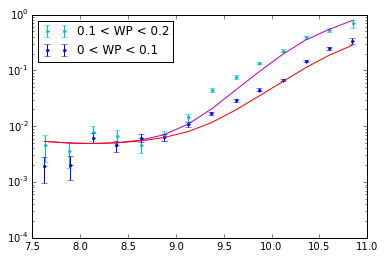

In [50]:
plot_fit_grouped(fit.parvals, 'mag', 0.25, wp_filter(0.10, 0.20), log=True, colors='cm', label='0.1 < WP < 0.2')
plot_fit_grouped(fit.parvals, 'mag', 0.25, wp_filter(0.0, 0.10), log=True, colors='br', label='0 < WP < 0.1')
plt.legend(loc='best');

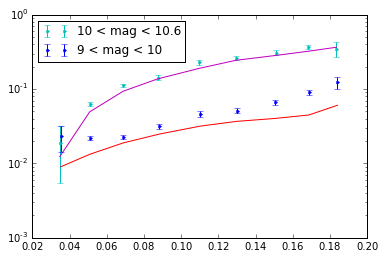

In [51]:
plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, mag_filter(10, 10.6), log=True, colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, mag_filter(9, 10), log=True, colors='br', label='9 < mag < 10')
plt.legend(loc='best');

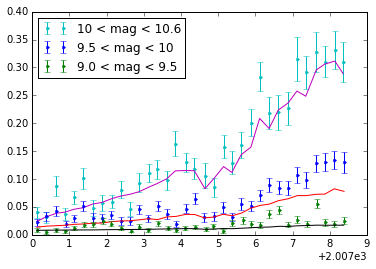

In [52]:
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(10, 10.6), colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(9.5, 10), colors='br', label='9.5 < mag < 10')
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(9.0, 9.5),  colors='gk', label='9.0 < mag < 9.5')
plt.legend(loc='best');